# Vacancy Classification SF02
## Условия задачи

Мы владельцы специфического Job-сайта и нам дали большой датасет вакансий. Одни вакансии нам интересны по своей тематике, другие не интересны (target 1 и 0 соответственно). Часть вакансий была размечена людскими ресурсами.

Ваша задача обучить классификатор, который на основе размеченной выборки умеет определять интересные вакансии для нашего сайта.

Метрика качества ROC_AUC.
ИСПОЛЬЗОВАТЬ ВНЕШНИЕ ДАННЫЕ С JOB-сайтов = ЗАПРЕЩЕНО
ИСПОЛЬЗОВАТЬ другие ВНЕШНИЕ ДАННЫЕ = только с разрешения организатора (смотри Discussion)
Результат засчитывается только при наличие кода, который этот результат повторяет
Участие индивидуальное

## Описание данных

train.csv - данные для обучения<br>
test.csv - данные для подготовки самбита и проверки<br>
sampleSubmission.csv - пример корректного но бесполезного сабмита<br>
other.csv - необязательные данные для доп.статистик и прочих извращений (например обучение word2vec-а)<br>

## Описание полей

id - внутренний идетификатор<br>
name - название вакансии<br>
description - текст вакансии<br>
target - класс заинтересованности<br>

In [1]:
!ls

HW06+morph.ipynb     result.csv           test.csv
HW06.ipynb           result2.csv          train.csv
other.csv            sampleSubmission.csv Условия.docx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

## Грузим данные

In [3]:
train = pd.read_csv('train.csv', sep='\t', encoding='utf8')

In [4]:
train.shape

(200000, 4)

In [5]:
train.head()

,id,name,description,target
0,0,Заведующий отделом/секцией в магазин YORK (Уру...,<p><strong>В НОВЫЙ МАГАЗИН YORK (хозтовары) пр...,1
1,1,Наладчик станков и манипуляторов с ПУ,Обязанности:работа на токарных станках с ЧПУ T...,0
2,2,Разработчик С++ (Криптограф),<strong>Требования:</strong> <ul> <li>Опыт про...,0
3,3,Фрезеровщик,<p>Условия:</p> <ul> <li>На работу вахтовым ме...,0
4,4,Мерчендайзер/продавец-консультант,<p><strong>Компания Палладиум Стандарт - призн...,1


## Аналитика

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
id             200000 non-null int64
name           200000 non-null object
description    200000 non-null object
target         200000 non-null int64
dtypes: int64(2), object(2)
memory usage: 6.1+ MB


In [7]:
train.head().T

,0,1,2,3,4
id,0,1,2,3,4
name,Заведующий отделом/секцией в магазин YORK (Уру...,Наладчик станков и манипуляторов с ПУ,Разработчик С++ (Криптограф),Фрезеровщик,Мерчендайзер/продавец-консультант
description,<p><strong>В НОВЫЙ МАГАЗИН YORK (хозтовары) пр...,Обязанности:работа на токарных станках с ЧПУ T...,<strong>Требования:</strong> <ul> <li>Опыт про...,<p>Условия:</p> <ul> <li>На работу вахтовым ме...,<p><strong>Компания Палладиум Стандарт - призн...
target,1,0,0,0,1


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# train['is_M'] = train['name'].map(lambda s: 'менеджер' in s)

In [10]:
train.head()

,id,name,description,target
0,0,Заведующий отделом/секцией в магазин YORK (Уру...,<p><strong>В НОВЫЙ МАГАЗИН YORK (хозтовары) пр...,1
1,1,Наладчик станков и манипуляторов с ПУ,Обязанности:работа на токарных станках с ЧПУ T...,0
2,2,Разработчик С++ (Криптограф),<strong>Требования:</strong> <ul> <li>Опыт про...,0
3,3,Фрезеровщик,<p>Условия:</p> <ul> <li>На работу вахтовым ме...,0
4,4,Мерчендайзер/продавец-консультант,<p><strong>Компания Палладиум Стандарт - призн...,1


In [11]:
import seaborn as sns

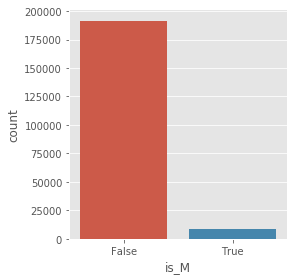

In [12]:
sns.factorplot('is_M',data=train,kind='count');

## Очищаем данные
Удаляем html теги. Используем BeautifulSoup

In [12]:
import pymorphy2
import re

ma = pymorphy2.MorphAnalyzer()

from bs4 import BeautifulSoup

# создадим вспомогательную функцию
def strip_words(sentence):
    # приводим к нижнему регистру
    sentence = sentence.lower()
    # цикл по каждому символу
    for ch in '.,()\/#-0123456789:;?"':
        # заменяем их на пробелы
        sentence = sentence.replace(ch, ' ')
    return sentence

# удалим html коды
def _remove_all_attrs(soup):
    text = soup
    soup = BeautifulSoup(text, "lxml")
    return soup.get_text()

# Пробуем нормировать сам текст
def clean_text(text):
    text = text.replace("\\", " ").replace(u"╚", " ").replace(u"╩", " ")
    text = text.lower()
    text = re.sub('\-\s\r\n\s{1,}|\-\s\r\n|\r\n', '', text) #deleting newlines and line-breaks
    text = re.sub('[.,:;_%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', text) #deleting symbols  
    #text = " ".join(ma.parse(str(word))[0].normal_form for word in text.split())
    text = ' '.join(word for word in text.split() if len(word)>3)
    #text = text.encode("utf-8")

    return text


Проверим

In [13]:
_remove_all_attrs(train['description'][2])

'Требования:  Опыт программирования на С++ Знание базовых алгоритмов, на которых основывается работа ПО, обеспечивающего шифрование и создание/проверку ЭЦП (SHA, MD5, RSA, PKCS-стандарты, сертификаты, удостоверяющие центры и т.п.) Знание и понимание базовых алгоритмов computer science.    Условия:  Стабильная, развивающаяся софт-компания в Железнодорожном районе. Сильная команда профессионалов. Интересные и разнообразные задачи. Возможность обучения и повышения профессионального уровня. Зарплата обсуждается по итогам собеседования, «белая». Официальное трудоустройство, полный соц. пакет (оплачиваемые отпуска и больничные, пенсионные отчисления в полном объеме). Обязательное медицинское страхование, ДМС. Корпоративное обучение. «Спортивная программа» — оплата 50% абонементов (4 клуба). Бесплатное обучение английскому языку. Ссуды на жилье (для сотрудников со стажем). Все выплаты официально оформляются. '

In [14]:
#train['description'] = train['description'].apply(_remove_all_attrs)

In [15]:
#train['description'] = train['description'].apply(strip_words)

In [16]:
#train['name'] = train['name'].apply(strip_words)

In [17]:
#train.head(5)

Склеим должность вакансии и ее описание для более лучшего результата

In [18]:
train['description_full'] = train['name'] + ' ' + train['description']

In [19]:
train['description_full'] = train['description_full'].apply(_remove_all_attrs)

In [20]:
train['description_full'] =  train['description_full'].apply(clean_text)

In [21]:
train.head(5)

,id,name,description,target,description_full
0,0,Заведующий отделом/секцией в магазин YORK (Уру...,<p><strong>В НОВЫЙ МАГАЗИН YORK (хозтовары) пр...,1,заведующий отделом секцией магазин york уручье...
1,1,Наладчик станков и манипуляторов с ПУ,Обязанности:работа на токарных станках с ЧПУ T...,0,наладчик станков манипуляторов обязанности раб...
2,2,Разработчик С++ (Криптограф),<strong>Требования:</strong> <ul> <li>Опыт про...,0,разработчик криптограф требования опыт програм...
3,3,Фрезеровщик,<p>Условия:</p> <ul> <li>На работу вахтовым ме...,0,фрезеровщик условия работу вахтовым методом ка...
4,4,Мерчендайзер/продавец-консультант,<p><strong>Компания Палладиум Стандарт - призн...,1,мерчендайзер продавец консультант компания пал...


Смотрим список символов

In [20]:
#print(''.join(sorted(list(set(' '.join(train['description_full']))))))


 !$%&'*+<=>@[]^_`abcdefghijklmnopqrstuvwxyz{|}~ £§©«¬­®¯°±²³´·¸»¼½¾×ßàáâãäåçèéêëîïðòóôö÷øùüýąčēęğıłńśşšťźżžəʼ˚̶͙́̆̇̈;φωабвгдежзийклмнопрстуфхцчшщъыьэюяѐёєѕіїўґғқңүұӓәө։ᅠ    ​‍‎‏‐‑‒–—―‘’‚“”„‟•…  ‪‭ ″‼⁃⁄⁠⁢⁪⁰€₽№™⅓⅞→↓↗⇒−∙√∞≈≠⋆⋝⎯⏳─┿█■▪▫▸►▽○●◦◾☀★☆☑☕☜☝☞☺♥⚜⚠⚡⛑✅✆✉✊✌✒✓✔✪❗❤➔➕➜➡➢⠀⤴⦁⩾⬅　、。《》【】にツ一上不与专业个中为了于交产人他以任作你供保全公关其具内准划制前办务历压参及友发受司合向和品团国型备外大奏好学定实导少展工年应建开心性悉意感愿或战技抗拓挑据掌接提握数整方施有朋本术机构架标核案沿演熟理用的目相研神科究等算管精组织经规解言謝计设语负责过选通队障面项领验﴾﴿️﻿（）＋，：；￼�


Часто используемые слова

In [21]:
# счётчик для слов
#from collections import Counter
# удалим лишние пробелы
#words = ' '.join(train['description_full']).split()
#cnt = Counter(words)
# возьмём топ 20 слов
#common = cnt.most_common(20)
#' '.join(pair[0] for pair in common)

'и в с на работы по опыт • работа обязанности для от требования компании условия знание к мы график возможность'

Часто используемые пары слов (биграммы)

In [22]:
#prev = words[0]
#pairs = []
#for w in words[1:]:
    # добавляем в список предыдущее и текущее слово
#    pairs.append(prev + ' '+ w)
#    prev = w
#cnt = Counter(pairs)
#common = cnt.most_common(20)
#', '.join(pair[0] for pair in common)

'опыт работы, график работы, тк рф, заработная плата, работы с, работы в, работа в, карьерного роста, в соответствии, соответствии с, работа с, с до, участие в, каждого кто, по тк, рабочий день, и карьерного, раза в, профессионального и, оформление в'

Тройки слов

In [23]:
#triples = [pair + ' ' + word for pair, word in zip(pairs[1:], words[3:])]
#cnt = Counter(triples)
#common = cnt.most_common(10)
#', '.join(triple[0] for triple in common)

'опыт работы в, в соответствии с, профессионального и карьерного, и карьерного роста, соответствии с тк, с тк рф, оформление в соответствии, опыт работы с, по тк рф, оформление по тк'

In [24]:
#train['target'].value_counts()

0    106436
1     93564
Name: target, dtype: int64

In [25]:
#train['target'].value_counts().plot(kind = 'pie', figsize = (5,5));

In [26]:
# вытаскиваем из библиотеки алгоритм 
#from sklearn.feature_extraction.text import CountVectorizer
# настраиваем: нужны слова, которые встречались минимум в 2...
# ... но не более чем в 10% документов
#vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor =None, stop_words = None, min_df = 2, max_df = 0.1)
# показываем алгоритму данные (чтобы пронумеровал слова)
#train_data = vectorizer.fit_transform(train['description']);
#train_data = train_data.toarray()
# заставляем его превратить список текстов в матрицу из чисел
#vec = vectorizer.transform(train['description'])
#print(vec.shape)

(200000, 125071)


In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve


def plot_roc_curve(predictions, yval):
    try:
        preds = predictions[:,1]
    except:
        preds = np.array(predictions)
    fpr, tpr, threshold = roc_curve(yval, preds)
    roc_auc = auc(fpr, tpr)
    with plt.rc_context({'xtick.color':'white', 'ytick.color':'white',
                     'axes.labelcolor':'white'}):
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
def visualize_coefficients(classifier, feature_names, n_top_features=10):
    
    ### визулизирует влияние факторов на целевую переменную
    
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
   
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [24]:
model = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', 
                             ngram_range=(1,1),
                             max_df=0.95, min_df=5)),
    ('clf', LogisticRegression()),
])


model2 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', 
                             ngram_range=(1,1))),
    ('clf', LogisticRegression()),
])

In [25]:
train['description_full'][:10]

0    заведующий отделом секцией магазин york уручье...
1    наладчик станков манипуляторов обязанности раб...
2    разработчик криптограф требования опыт програм...
3    фрезеровщик условия работу вахтовым методом ка...
4    мерчендайзер продавец консультант компания пал...
5    мастер эксплуатации зданий обязанности обеспеч...
6    торговый представитель стабильное распростране...
7    торговый представитель обязанности функционал ...
8    менеджер продажам обязанности продажа садовой ...
9    менеджер работе ключевыми клиентами posm обяза...
Name: description_full, dtype: object

In [26]:
y = train.target.values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train['description_full'], y, test_size=0.3)

In [28]:
model.fit(X_train, y_train)
model2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

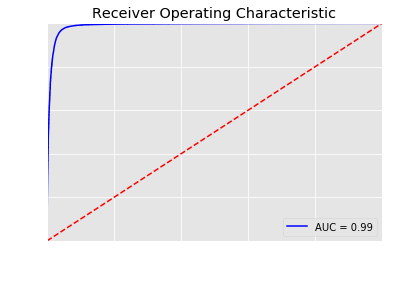

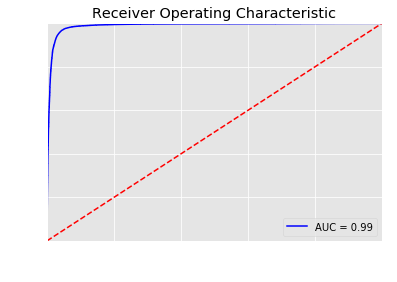

In [29]:
plot_roc_curve(model.predict_proba(X_test), y_test)

plot_roc_curve(model2.predict_proba(X_test), y_test)

## Готовим тестовую выборку

In [30]:
test = pd.read_csv('test.csv', sep='\t', encoding='utf8')

In [31]:
test.shape

(170179, 3)

In [32]:
test['description_full'] = test['name'] + ' ' + test['description']

In [33]:
test['description_full'] = test['description_full'].apply(_remove_all_attrs)

In [34]:
test['description_full'] =  test['description_full'].apply(clean_text)

In [28]:
#test['description'] = test['description'].apply(_remove_all_attrs)

In [29]:
#test['description'] = test['description'].apply(strip_words)

In [30]:
#test['name'] = test['name'].apply(strip_words)

In [31]:
#test['description_full'] = test['name'] + ' ' + test['description']

In [35]:
test.head(10)

,id,name,description,description_full
0,200000,Дизайнер-консультант мебели,<p><strong>Обязанности:</strong></p> <ul> <li>...,дизайнер консультант мебели обязанности работа...
1,200001,Продавец-консультант (ТЦ на Пушкина),<p><strong>Обязанности</strong>:</p> <p>∙ конс...,продавец консультант пушкина обязанности консу...
2,200002,Менеджер по продажам,<p>Торговый Дом «Форт» это ведущая компания Пе...,менеджер продажам торговый «форт» ведущая комп...
3,200003,Продавец-консультант в магазин одежды (ТЦ Волн...,<p><strong>Требуются продавцы консультанты в м...,продавец консультант магазин одежды волна ново...
4,200004,Специалист по охране труда,<strong>Обязанности:</strong> <ul> <li> <p>осу...,специалист охране труда обязанности осуществле...
5,200005,Эксперт по обеспечению качества при сооружении...,<p><strong>Обязанности:</strong></p> <ul> <li>...,эксперт обеспечению качества сооружении рубежо...
6,200006,Торговый представитель (Арзамас),<p><strong>Обязанности:</strong></p> <ul> <li>...,торговый представитель арзамас обязанности вед...
7,200007,Заместитель генерального директора по производ...,<p><strong>Обязанности:</strong></p> <ul> <li>...,заместитель генерального директора производств...
8,200008,Backend Rust developer,<p><strong>Storiqa </strong>- это площадка для...,backend rust developer storiqa площадка торгов...
9,200009,Дизайнер-конструктор 3D,<p><strong>Обязанности:</strong></p> <ul> <li>...,дизайнер конструктор обязанности адаптация диз...


In [36]:
test_preds = model.predict(X=test['description_full'])

In [37]:
test_preds

array([1, 1, 1, ..., 0, 0, 0])

In [38]:
submission = pd.DataFrame({"id":test["id"],
                           "target":test_preds})

In [39]:
submission.to_csv("result3.csv", 
                  index=False)  

In [40]:
!ls

HW06+morph.ipynb     result2.csv          train.csv
HW06.ipynb           result3.csv          Условия.docx
other.csv            sampleSubmission.csv
result.csv           test.csv
